<a href="https://colab.research.google.com/github/vishalmysore/AI/blob/main/examples/images/face_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas

In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
!pip install numpy

In [ ]:
!pip install insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 47.5 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1054130 sha256=2038bdeda4d0fd5630c976eeab33bc14e51f65a6701275b98a80491b06974b12
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [ ]:
!pip install opencv-python

In [ ]:
#install only if needed
#!pip install matplotlib

In [ ]:
#@title Iterate and create embeddings
#@markdown iterate through the directory and foldername will be name of the person
#@markdown create a directory called pics and add files there
import os
from tqdm import tqdm
from glob import glob
import numpy as np
import cv2 as cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data  import get_image as ins_get_image

app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))
names = []
embeddings =  []

folders = os.listdir(f'sample_data/pics')
for folder in tqdm(folders):
  if ".ipynb_checkpoints" in folder: continue
  print(folder)
  img_paths = glob(f'sample_data/pics/{folder}/*')
  for img_path in img_paths:
       img = cv2.imread(img_path)
       if img is None: continue
       faces = app.get(img)
       if len(faces) != 1: continue
       face = faces[0]
       names.append(folder)
       embeddings.append(face.normed_embedding)

embeddings = np.stack(embeddings, axis=0)

In [ ]:
#@title Match Face to the embeddings
#@markdown this code will match the existing embeddings and provide a score
import cv2
import numpy as np
from insightface.app import FaceAnalysis

def recognize_face(input_img, known_embeddings, app):
    # Perform face analysis on the input image
    faces = app.get(input_img)

    # Check if exactly one face is detected
    if len(faces) != 1:
        return "No face or multiple faces detected"

    # Retrieve the embedding for the detected face
    detected_embedding = faces[0].normed_embedding

    # Calculate similarity scores with known embeddings
    scores = np.dot(detected_embedding, np.array(known_embeddings).T)
    scores = np.clip(scores, 0., 1.)

    # Find the index with the highest score
    idx = np.argmax(scores)
    max_score = scores[idx]

    # Check if the maximum score is above a certain threshold (adjust as needed)
    threshold = 0.7
    if max_score >= threshold:
        recognized_name = names[idx]
        return f"Face recognized as {recognized_name} with a confidence score of {max_score:.2f}"
    else:
        return "Face not recognized"

# Assuming 'input_img_path' is the path to the input face image
input_img = cv2.imread("sample_data/pics/vishal/vishal.jpg")

# Call the recognize_face function
result = recognize_face(input_img, embeddings, app)
print(result)


Face recognized as vishal with a confidence score of 1.00


In [ ]:
#@title funcion to detect the person
def detect_person(img, detector):
    bboxes, kpss = detector.detect(img)
    bboxes = np.round(bboxes[:,:4]).astype(np.int)
    kpss = np.round(kpss).astype(np.int)
    kpss[:,:,0] = np.clip(kpss[:,:,0], 0, img.shape[1])
    kpss[:,:,1] = np.clip(kpss[:,:,1], 0, img.shape[0])
    vbboxes = bboxes.copy()
    vbboxes[:,0] = kpss[:, 0, 0]
    vbboxes[:,1] = kpss[:, 0, 1]
    vbboxes[:,2] = kpss[:, 4, 0]
    vbboxes[:,3] = kpss[:, 4, 1]
    return bboxes, vbboxes


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


<ipython-input-10-7a0535d8e227>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bboxes = np.round(bboxes[:,:4]).astype(np.int)
<ipython-input-10-7a0535d8e227>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

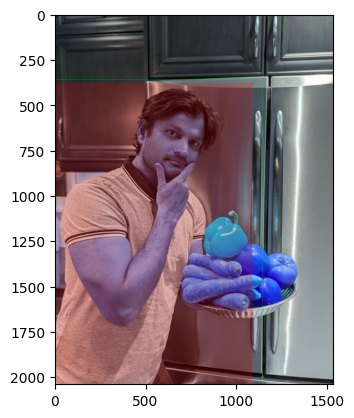

In [ ]:
    #@title Detect if there is person in the image
    import glob
    import matplotlib.pyplot as plt
    detector = insightface.model_zoo.get_model('scrfd_person_2.5g.onnx', download=True)
    detector.prepare(0, nms_thresh=0.5, input_size=(640, 640))
    img_paths = glob.glob('sample_data/pics/vishal/*.jpg')
    for img_path in img_paths:
        img = cv2.imread(img_path)
        bboxes, vbboxes = detect_person(img, detector)
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i]
            vbbox = vbboxes[i]
            x1,y1,x2,y2 = bbox
            vx1,vy1,vx2,vy2 = vbbox
            cv2.rectangle(img, (x1,y1)  , (x2,y2) , (0,255,0) , 1)
            alpha = 0.8
            color = (255, 0, 0)
            for c in range(3):
                img[vy1:vy2,vx1:vx2,c] = img[vy1:vy2, vx1:vx2, c]*alpha + color[c]*(1.0-alpha)
            cv2.circle(img, (vx1,vy1) , 1, color , 2)
            cv2.circle(img, (vx1,vy2) , 1, color , 2)
            cv2.circle(img, (vx2,vy1) , 1, color , 2)
            cv2.circle(img, (vx2,vy2) , 1, color , 2)
        filename = img_path.split('/')[-1]
        plt.imshow(img)
        img


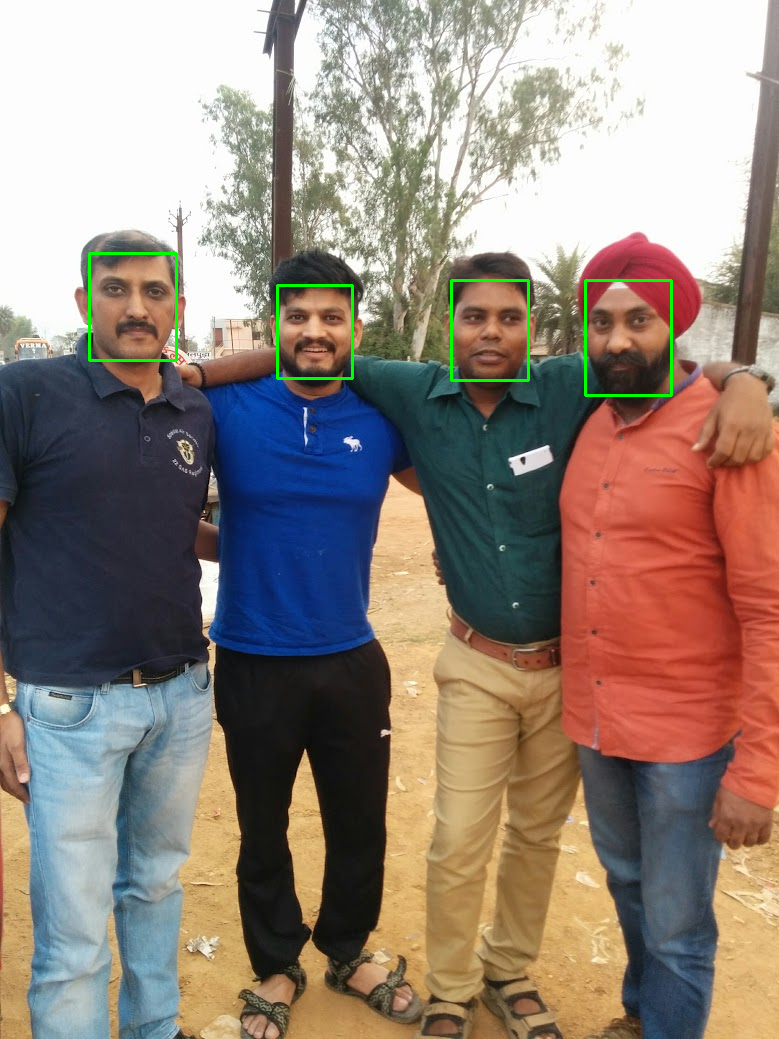

In [ ]:
#@title annotate multiple faces
#@markdown upload a file named firends.jpg in the folder sample_data/images/
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from google.colab.patches import cv2_imshow
def annotate_faces(input_img, app):
    # Perform face analysis on the input image
    faces = app.get(input_img)

    # Draw rectangles around detected faces
    annotated_img = input_img.copy()
    for face in faces:
        bbox = face.bbox.astype(int)
        cv2.rectangle(annotated_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Display or save the annotated image
    cv2_imshow(annotated_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Assuming 'input_img_path' is the path to the input image
input_img = cv2.imread("sample_data/images/friends.jpg")

# Call the annotate_faces function
annotate_faces(input_img, app)


In [ ]:
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


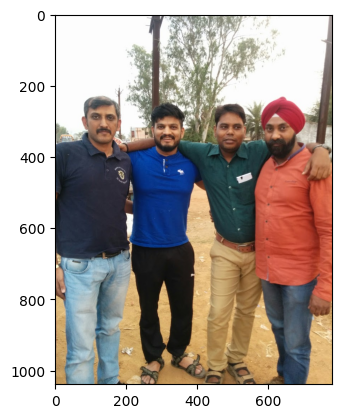

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("sample_data/images/friends.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

In [ ]:
faces = app.get(img)

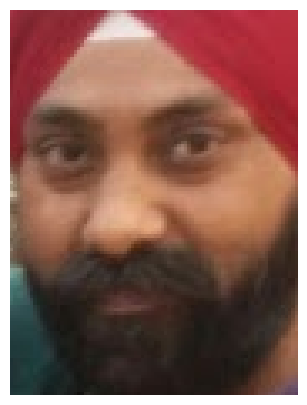

In [ ]:
#if there is only one face
fig,axs = plt.subplots(1,1, figsize=(12,5))
for i, face in enumerate (faces):
    bbox = face['bbox']
    bbox = [int(b) for b in bbox]
    axs.imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
    axs.axis('off')

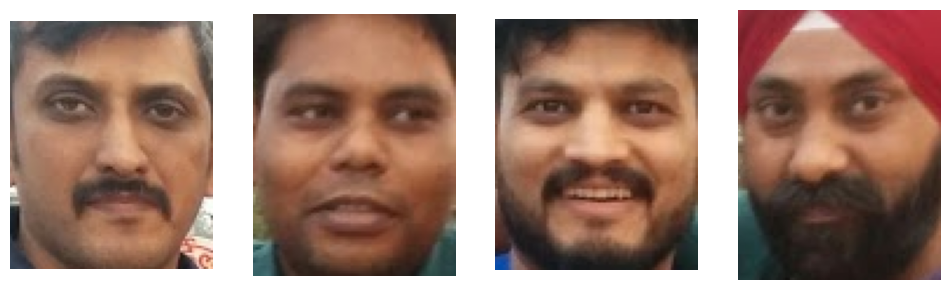

In [ ]:
#multiple faces
fig,axs = plt.subplots(1,len(faces), figsize=(12,5))
for i, face in enumerate (faces):
    bbox = face['bbox']
    bbox = [int(b) for b in bbox]
    axs[i].imshow(img[bbox[1]:bbox[3], bbox[0]:bbox[2], ::-1])
    axs[i].axis('off')